In [230]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Données

In [ ]:
import pandas as pd

week = pd.read_csv("weeks_received.csv")
week.head()


,week_start,week_end,distance_km,sessions,duration_min,low_intensity_pct,high_intensity_pct,variation_km,longest_run_km,weekly_load,sig_weekly_avg_km,sig_weekly_std_km,sig_trend_12w_pct,sig_z4_z5_avg_pct,sig_z4_z5_trend_12w_pct,sig_acwr_avg,sig_acwr_max,sig_load_std_trend_12w_pct
0,2024-01-22,2024-01-29,23.397820,3,142.396351,0.428429,0.571571,0.000000,14.330868,223.785970,27.738252,7.981101,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857
1,2024-01-29,2024-02-05,17.548586,5,110.718513,0.686326,0.313674,-5.849234,10.032441,145.448065,27.738252,7.981101,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857
2,2024-02-05,2024-02-12,29.044244,6,178.185437,0.355257,0.644743,11.495659,13.732183,293.069172,27.738252,7.981101,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857
3,2024-02-12,2024-02-19,30.469471,4,180.692490,0.882353,0.117647,1.425227,10.299794,201.950475,27.738252,7.981101,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857
4,2024-02-19,2024-02-26,0.000000,0,0.000000,0.000000,0.000000,-30.469471,0.000000,0.000000,27.738252,7.981101,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857


In [229]:
sessions = pd.read_csv("sessions_received.csv")
sessions.head()

,date,distance_km,duration_min,pace_min_per_km,z1_min,z2_min,z3_min,z4_min,z5_min,low_intensity_pct,high_intensity_pct
0,2024-01-14,12.840000,76.000000,5.919003,0.500000,5.150000,30.425000,37.700017,0.116667,0.488215,0.511785
1,2024-01-14,3.151658,18.683731,5.928222,0.000000,0.000000,8.800000,6.516667,0.000000,0.574538,0.425462
2,2024-01-16,9.780000,56.882490,5.816205,0.000000,0.800000,8.233333,34.833257,10.133333,0.167284,0.832716
3,2024-01-18,7.012101,48.436705,6.907588,3.216667,21.649982,25.400000,0.783333,0.000000,0.984656,0.015344
4,2024-01-21,13.725293,81.097746,5.908635,0.000000,5.925000,30.970814,42.416679,1.916667,0.454219,0.545781


# TEST : clustering des données des SEANCES à partir de 2025-09-14 (avec capteur cardiaque donc plus precis)

   distance_km  duration_min  pace_min_per_km  low_intensity_pct  \
0    11.149497     66.050474         5.935859           0.437439   
1     5.691435     37.833846         6.673628           0.918058   
2    11.791240     75.761204         6.437886           0.909061   

   high_intensity_pct  
0            0.562561  
1            0.081942  
2            0.090939  


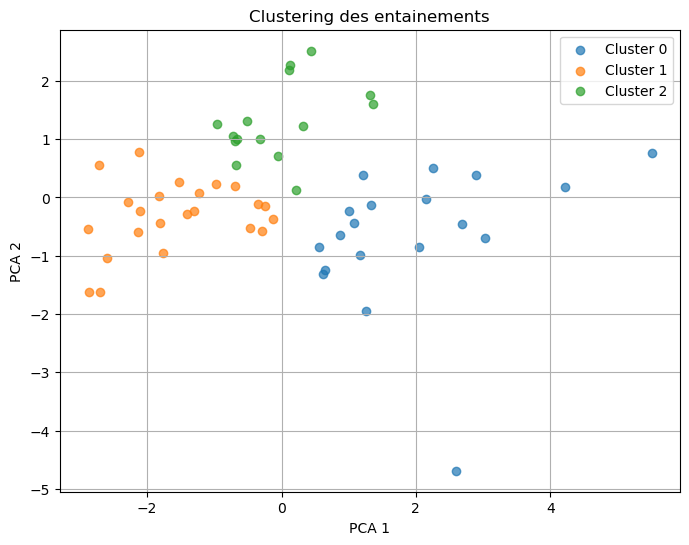

   cluster_session  min_distance_km  min_duration_min  min_pace  \
0                0         3.013890         15.612216  5.180089   
1                1         0.821181          5.411381  6.589755   
2                2         9.024648         59.821317  6.628660   

   max_distance_km  max_duration_min  max_pace  
0        21.332739        114.536257  5.369037  
1         8.373900         51.572004  6.158660  
2        15.260628         94.177650  6.171283  


In [232]:
sessions["date"] = pd.to_datetime(sessions["date"])
# Filter from 2025-09-14
sessions_filt = sessions[sessions["date"] >= "2025-09-14"].copy()
# Remove rows with no intensity info
sessions_filt = sessions_filt[
    ~(
        (sessions_filt["low_intensity_pct"] == 0)
        & (sessions_filt["high_intensity_pct"] == 0)
    )
]
features = [
    "distance_km",
    "duration_min",
    "pace_min_per_km",
    "low_intensity_pct",
    "high_intensity_pct",
]

X = sessions_filt[features].fillna(0)
# Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3-cluster KMeans
kmeans3 = KMeans(n_clusters=3, random_state=42)
sessions_filt["cluster_session"] = kmeans3.fit_predict(X_scaled)

# Compute centroids
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans3.cluster_centers_), columns=features
)

(
    sessions_filt[
        ["date", "distance_km", "duration_min", "pace_min_per_km", "cluster_session"]
    ].head(),
    sessions_filt.shape,
    centroids,
)

print(centroids)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

sessions_filt["pca1"] = X_pca[:, 0]
sessions_filt["pca2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))

for c in sorted(sessions_filt["cluster_session"].unique()):
    subset = sessions_filt[sessions_filt["cluster_session"] == c]
    plt.scatter(subset["pca1"], subset["pca2"], label=f"Cluster {c}", alpha=0.7)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clustering des entainements")
plt.legend()
plt.grid(True)
plt.show()

# Compute min/max distance per cluster
rows = []
for c in sorted(sessions_filt["cluster_session"].unique()):
    cluster_df = sessions_filt[sessions_filt["cluster_session"] == c]
    min_idx = cluster_df["distance_km"].idxmin()
    max_idx = cluster_df["distance_km"].idxmax()
    rows.append(
        {
            "cluster_session": c,
            "min_distance_km": cluster_df.loc[min_idx, "distance_km"],
            "min_duration_min": cluster_df.loc[min_idx, "duration_min"],
            "min_pace": cluster_df.loc[min_idx, "pace_min_per_km"],
            "max_distance_km": cluster_df.loc[max_idx, "distance_km"],
            "max_duration_min": cluster_df.loc[max_idx, "duration_min"],
            "max_pace": cluster_df.loc[max_idx, "pace_min_per_km"],
        }
    )

summary_df = pd.DataFrame(rows)
print(summary_df)


🔴 Cluster 0 — Séances intensives / qualitatives => intensive
- Distance : 11.5 km
- Durée : 67 min
- Allure : ~5:50 / km
- ≈ 53 % haute intensité
- Interprétation : tempo, allure soutenue, fractionné long, sorties longues avec seuil
- Impact entraînement : fort stimulus, principal facteur de fatigue, à limiter en fréquence

🟢 Cluster 1 — Séances courtes très faciles / récupération => facile
- Distance : 4.7 km
- Durée : 32 min
- Allure : ~6:45 / km
- ≈ 100 % basse intensité
- Interprétation : Récupération, reprise, ou contrainte (temps/fatigue).
- Impact : récupération active, signal de fatigue si fréquent

🟡 Cluster 2 — Footings d’endurance (modérés) => endurence
- Distance : 10.5 km
- Durée : 67 min
- Allure : ~6:22 / km
- ≈ 90 % basse intensité
- Interprétation : Endurance fondamentale, séances “cœur” de l’entraînement.
- Impact : base aérobie, faible risque, indispensable à la progression

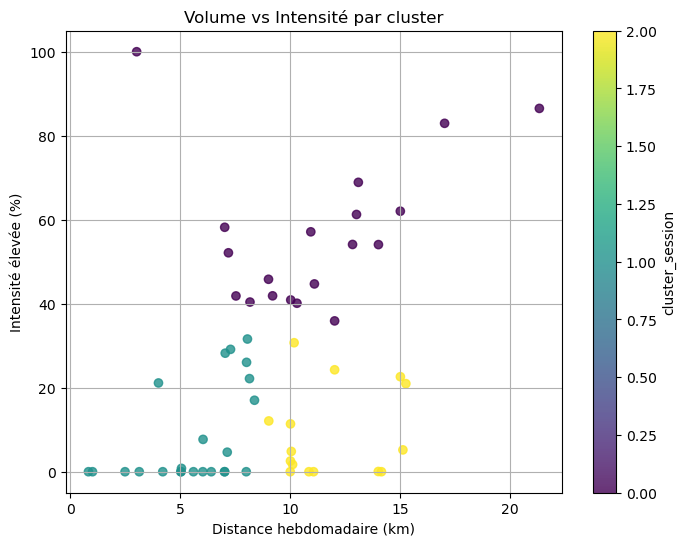

In [234]:
plt.figure(figsize=(8, 6))

plt.scatter(
    sessions_filt["distance_km"],
    sessions_filt["high_intensity_pct"] * 100,
    c=sessions_filt["cluster_session"],
    alpha=0.8,
)

plt.xlabel("Distance hebdomadaire (km)")
plt.ylabel("Intensité élevée (%)")
plt.title("Volume vs Intensité par cluster")
plt.colorbar(label="cluster_session")
plt.grid(True)
plt.show()


On observe que :
- des séances de même distance peuvent avoir des intensités très différentes
- le cluster intensif se situe clairement en haut (intensité élevée)
- les clusters faciles restent proches de 0–20 % d’intensité

Le volume seul ne suffit pas à caractériser la charge d’entraînement.

<Figure size 800x500 with 0 Axes>

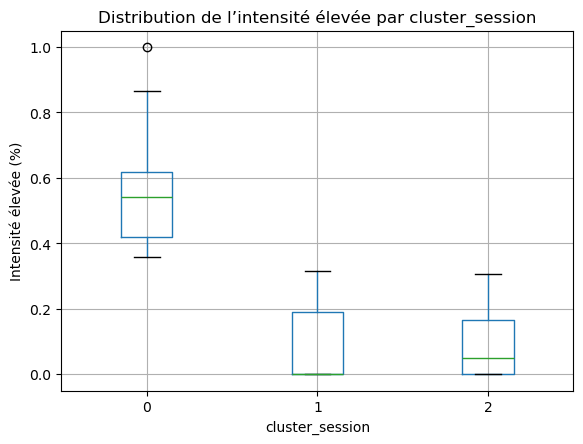

In [235]:
plt.figure(figsize=(8, 5))
sessions_filt.boxplot(column="high_intensity_pct", by="cluster_session", grid=True)

plt.suptitle("")
plt.title("Distribution de l’intensité élevée par cluster_session")
plt.xlabel("cluster_session")
plt.ylabel("Intensité élevée (%)")
plt.show()


Cluster 0 :
- intensité élevée médiane autour de 50–60 %
- forte dispersion
- séances clairement exigeantes

Clusters 1 et 2 :
- intensité faible
- valeurs proches de 0
- peu de variabilité

<Figure size 800x500 with 0 Axes>

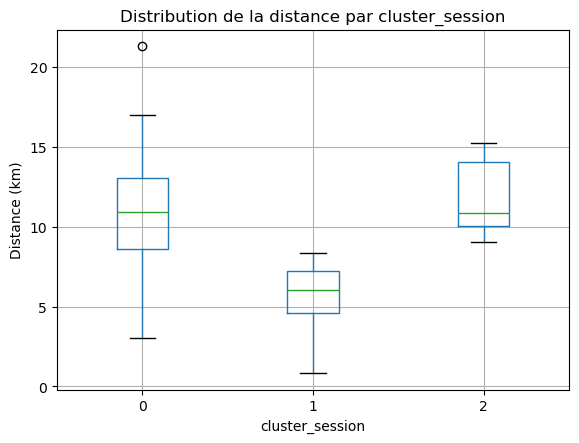

In [236]:
plt.figure(figsize=(8, 5))
sessions_filt.boxplot(column="distance_km", by="cluster_session", grid=True)

plt.suptitle("")
plt.title("Distribution de la distance par cluster_session")
plt.xlabel("cluster_session")
plt.ylabel("Distance (km)")
plt.show()


- Les clusters ne sont pas séparés uniquement par la distance
- Cluster 0 et cluster 2 peuvent avoir des distances similaires
- Pourtant, ils n’ont pas la même intensité (vu graphique précédent)

In [ ]:
centroids

,distance_km,duration_min,pace_min_per_km,low_intensity_pct,high_intensity_pct
0,11.149497,66.050474,5.935859,0.437439,0.562561
1,5.691435,37.833846,6.673628,0.918058,0.081942
2,11.791240,75.761204,6.437886,0.909061,0.090939


# TEST : Clustering par SEMAINE avec le meme filtre sur les dates

Dataset prêt : (19, 18)
2025-09-08 00:00:00
19
              distance_km  sessions  duration_min  low_intensity_pct  \
cluster_week                                                           
0                   29.53      3.38        189.92               0.85   
1                   31.96      3.56        197.18               0.60   
2                    8.80      1.00         55.32               0.65   

              high_intensity_pct  weekly_load  
cluster_week                                   
0                           0.15       217.99  
1                           0.40       276.07  
2                           0.35        74.92  


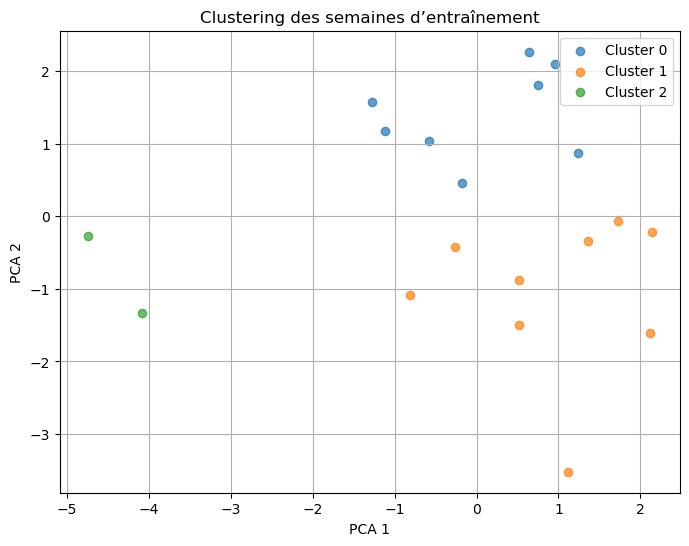

   cluster_week  min_distance_km  min_duration_min  max_distance_km  \
0             0        23.939647        148.198547        35.172801   
1             1        24.854587        158.394251        38.074161   
2             2         7.284365         47.135469        10.306906   

   max_duration_min  
0        229.361943  
1        233.007170  
2         63.495290  


In [ ]:
week["week_start"] = pd.to_datetime(week["week_start"])
week["week_end"] = pd.to_datetime(week["week_end"])
week = week[week["week_start"] >= "2025-09-08"].copy()

# Supprimer les semaines incomplètes si besoin
week = week.dropna(subset=["distance_km", "sessions", "duration_min"])

week = week.reset_index(drop=True)
print("Dataset prêt :", week.shape)
print(week["week_start"].min())
print(len(week))
FEATURES = [
    "distance_km",
    "sessions",
    "duration_min",
    "low_intensity_pct",
    "high_intensity_pct",
    "weekly_load",
]

X = week[FEATURES].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)

week["cluster_week"] = kmeans.fit_predict(X_scaled)

print(week.groupby("cluster_week")[FEATURES].mean().round(2))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

week["pca1"] = X_pca[:, 0]
week["pca2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))

for c in sorted(week["cluster_week"].unique()):
    subset = week[week["cluster_week"] == c]
    plt.scatter(subset["pca1"], subset["pca2"], label=f"Cluster {c}", alpha=0.7)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clustering des semaines d’entraînement")
plt.legend()
plt.grid(True)
plt.show()

# Compute min/max distance per cluster
rows = []
for c in sorted(week["cluster_week"].unique()):
    cluster_df = week[week["cluster_week"] == c]
    min_idx = cluster_df["distance_km"].idxmin()
    max_idx = cluster_df["distance_km"].idxmax()
    rows.append(
        {
            "cluster_week": c,
            "min_distance_km": cluster_df.loc[min_idx, "distance_km"],
            "min_duration_min": cluster_df.loc[min_idx, "duration_min"],
            "max_distance_km": cluster_df.loc[max_idx, "distance_km"],
            "max_duration_min": cluster_df.loc[max_idx, "duration_min"],
        }
    )

summary_df = pd.DataFrame(rows)
print(summary_df)


🟢 Cluster 0 — Semaines d’endurance / charge maîtrisée => endurance
- distance_km : moyenne à élevée
- sessions : régulières (3–4)
- low_intensity_pct : élevé
- high_intensity_pct : faible
- longest_run_km : présent
- weekly_load : modéré
- variation_km : faible ou positive légère
- coach : Semaines structurées, majoritairement faciles, idéales pour construire la base aérobie.
- Recommandation associée : maintenir la structure, ajouter ponctuellement de l’intensité, progression douce


🟡 Cluster B — Semaines légères / récupération ou contrainte => intensive
- distance_km : faible
- sessions : peu nombreuses
- duration_min : faible
- intensité faible
- weekly_load : bas
- variation_km : souvent négative
- coach : Semaines de récupération, de reprise ou contraintes par le contexte.
- Recommandation : augmenter la fréquence avant le volume, rester en basse intensité, pas de séance qualitative

🔴 Cluster C — Semaines intensives / charge élevée => courte/déséquilibrée
- distance_km : moyenne à élevée
- high_intensity_pct : élevé
- weekly_load : élevé
- variation_km : souvent positive
- longest_run_km : parfois long + intense
- coach : Semaines exigeantes, à fort stress physiologique.
- Recommandation : attention à l’enchaînement, prévoir une semaine allégée ensuite, surveiller fatigue / signaux faibles

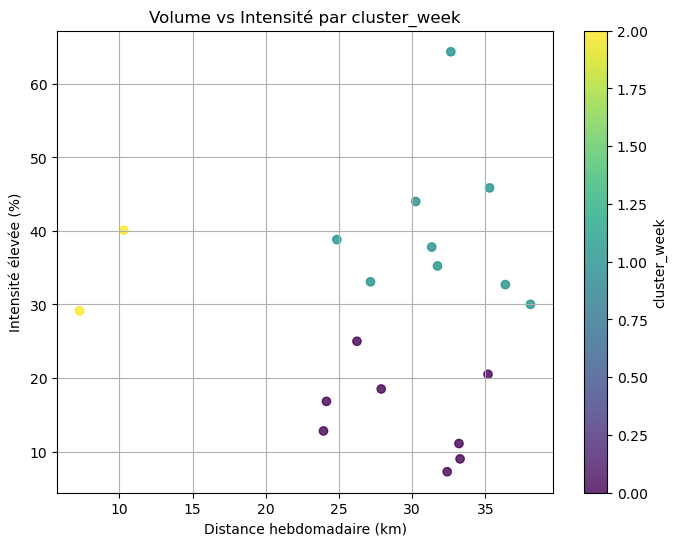

In [ ]:
plt.figure(figsize=(8, 6))

plt.scatter(
    week["distance_km"],
    week["high_intensity_pct"] * 100,
    c=week["cluster_week"],
    alpha=0.8,
)

plt.xlabel("Distance hebdomadaire (km)")
plt.ylabel("Intensité élevée (%)")
plt.title("Volume vs Intensité par cluster_week")
plt.colorbar(label="cluster_week")
plt.grid(True)
plt.show()


# Liaisons

Clusters semaines
- Cluster 0 → Semaine maîtrisée / endurance
- Cluster 1 → Semaine intensive / charge élevée
- Cluster 2 → Semaine courte déséquilibrée (contrainte / reprise)

Clusters séances
- Cluster 0 → Séance intensive
- Cluster 1 → Séance facile / récupération
- Cluster 2 → Séance d’endurance

## Liaison causale
Pourquoi une semaine est dans un cluster donné

Montrer que : les clusters hebdomadaires sont expliqués par la composition des séances



| cluster séance | réalité                            |
| ------- | ---------------------------------- |
| 0       | séances **intensives**             |
| 1       | séances **faciles / récupération** |
| 2       | séances **d’endurance**            |


In [239]:
# 1 - Ajouter la semaine "week_start" aux séances sessions_filt
# Pour chaque séance, on prend sa date, la convertis en semaine calendaire, récupères le début de cette semaine
sessions_filt["week_start"] = (
    sessions_filt["date"].dt.to_period("W").apply(lambda r: r.start_time)
)

sessions_filt.head()

,date,distance_km,duration_min,pace_min_per_km,z1_min,z2_min,z3_min,z4_min,z5_min,low_intensity_pct,high_intensity_pct,cluster_session,pca1,pca2,week_start
247,2025-09-14,1.006600,6.514466,6.471751,4.083333,3.416667,0.000000,0.000000,0.000000,1.000000,0.000000,1,-2.707762,-1.629200,2025-09-08
248,2025-09-14,5.052251,32.672392,6.466898,0.000000,0.000000,33.179167,0.266667,0.000000,0.992027,0.007973,1,-1.810941,-0.445824,2025-09-08
249,2025-09-14,3.013890,15.612216,5.180089,0.000000,0.000000,0.000000,12.821008,0.133333,0.000000,1.000000,0,2.603481,-4.687781,2025-09-08
250,2025-09-14,0.821181,5.411381,6.589755,0.000000,0.000000,2.675000,0.000000,0.000000,1.000000,0.000000,1,-2.859706,-1.613951,2025-09-08
251,2025-09-16,12.835037,77.284413,6.021363,3.045059,20.325750,12.088602,3.950121,37.861200,0.458898,0.541102,0,2.157256,-0.024588,2025-09-15


In [ ]:
# 2 - distribution hebdomadaire des clusters
# Distribution des clusters de séances par semaine : 1 ligne = 1 semaine
# 1 ligne = 1 semaine
week_sessions_profile = (
    sessions_filt.groupby("week_start")["cluster_session"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .rename(columns={0: "intensity_pct", 1: "easy_pct", 2: "endurance_pct"})
    .rename_axis(None, axis=1)  
    .reset_index()
)

week_sessions_profile.head()


,week_start,intensity_pct,easy_pct,endurance_pct
0,2025-09-08,0.250000,0.750000,0.000000
1,2025-09-15,0.500000,0.000000,0.500000
2,2025-09-22,0.333333,0.333333,0.333333
3,2025-09-29,0.333333,0.333333,0.333333
4,2025-10-06,0.333333,0.000000,0.666667


le tableau represente POUR CHAQUE SEMAINE, la composition interne en types de séances

- 2025-09-08 : 75 % facile, 25 % intensité, 0 % endurance      
    semaine clairement légère / déséquilibrée, probablement reprise ou contrainte

- 2025-09-15 : 50 % intensité, 50 % endurance             
    semaine très exigeante, peu de récupération

- 2025-09-22 / 2025-09-29 : répartition équilibrée 1/3 – 1/3 – 1/3          
    semaines structurées, mais potentiellement fatigantes

easy_pct → récupération / facile

endurance_pct → endurance fondamentale

intensity_pct → séances qualitatives

In [ ]:
week.head()

,week_start,week_end,distance_km,sessions,duration_min,low_intensity_pct,high_intensity_pct,variation_km,longest_run_km,weekly_load,...,sig_weekly_std_km,sig_trend_12w_pct,sig_z4_z5_avg_pct,sig_z4_z5_trend_12w_pct,sig_acwr_avg,sig_acwr_max,sig_load_std_trend_12w_pct,cluster_week,pca1,pca2
0,2025-09-08,2025-09-15,31.725308,8,203.202304,0.647579,0.352421,1.785732,8.145728,274.815049,...,7.981101,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857,1,2.137448,-0.216060
1,2025-09-15,2025-09-22,24.854587,2,158.394251,0.611708,0.388292,-6.870721,12.835037,219.897530,...,7.981101,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857,1,-0.818991,-1.085625
2,2025-09-22,2025-09-29,35.172801,3,229.361943,0.794979,0.205021,10.318214,14.149791,276.385871,...,7.981101,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857,0,1.235957,0.865851
3,2025-09-29,2025-10-06,23.939647,3,148.198547,0.872016,0.127984,-11.233154,10.001428,167.165525,...,7.981101,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857,0,-1.276427,1.571421
4,2025-10-06,2025-10-13,38.074161,3,233.007170,0.699846,0.300154,14.134515,15.011332,302.945144,...,7.981101,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857,1,1.731293,-0.072582


In [ ]:
# 3 - on fusionne les deux datasets
# chaque ligne = 1 semaine
# avec : ses caractéristiques globales (km, charge, etc.) & sa structure interne (% des types de séances)

df_linked = week.merge(week_sessions_profile, on="week_start", how="left")

df_linked.head()

# 4 - on fait la moyenne des zones par cluster
df_linked.groupby("cluster_week")[
    ["easy_pct", "endurance_pct", "intensity_pct"]
].mean().round(2)



,easy_pct,endurance_pct,intensity_pct
cluster_week,,,
0,0.42,0.39,0.20
1,0.32,0.19,0.48
2,0.50,0.00,0.50


cluster = cluster de SEMAINES 

rappel :  

Clusters semaines : cluster_week
- Cluster 0 → Semaine maîtrisée / endurance
- Cluster 1 → Semaine intensive / charge élevée
- Cluster 2 → Semaine courte déséquilibrée (contrainte / reprise)

Clusters séances : cluster_session
- Cluster 0 → Séance intensive
- Cluster 1 → Séance facile / récupération
- Cluster 2 → Séance d’endurance

🟢 Cluster 0 — Semaines maîtrisées / équilibrées
- majorité de séances faciles + endurance
- intensité présente mais contrôlée (~20 %)
- structure relativement stable
- Interprétation : Semaines bien construites, adaptées à la progression.
- Rôle dans le système : cluster “cible”, état stable, possibilité de légère progression

🔴 Cluster 1 — Semaines intensives
- 48 % de séances intensives
- peu d’endurance
- récupération insuffisante
- Interprétation : Semaines exigeantes, à fort stress physiologique.
- Rôle RS : cluster à surveiller, déclenche des recommandations d’allègement

🟡 Cluster 2 — Semaines déséquilibrées / fragiles
- 50 % facile
- 50 % intensité
- 0 % endurance
- absence de base aérobie
- Interprétation : Semaines incohérentes : effort sans fondation.
- Rôle RS = signal d’alerte, besoin de restructuration

Les variables easy_pct, endurance_pct et intensity_pct décrivent la proportion de chaque type de séance au sein d’une semaine et permettent d’expliquer l’appartenance d’une semaine à un cluster donné.

## Liaison décisionnelle
Que recommander maintenant ?

Construire les transitions entre clusters de semaines

In [ ]:
df_sorted = week.sort_values("week_start").copy()
df_sorted["next_cluster_week"] = df_sorted["cluster_week"].shift(
    -1
)  # Le but : observer ce qui arrive APRÈS une semaine donnée, pas le deviner.
# On cherche à analyser des enchaînements passés pour en tirer des règles.
# cluster = cluster de la semaine courante
# next_cluster = cluster de la semaine suivante

Semaine 1 => cluster = 0      
Semaine 2 => cluster = 1   
Semaine 3 => cluster = 0  

Semaine 1 => cluster = 0 => next_cluster = 1       
Semaine 2 => cluster = 1 => next_cluster = 0          
Semaine 3 => cluster = 0 => next_cluster = cluster de la semaine 4        

In [248]:
# On construit une matrice de transition :
# lignes = cluster de la semaine actuelle
# colonnes = cluster de la semaine suivante
# valeurs = probabilités conditionnelles

transition_matrix = pd.crosstab(
    df_sorted["cluster_week"], df_sorted["next_cluster_week"], normalize="index"
).round(2)

transition_matrix  # matrice de transition = chaîne de Markov empirique????????????


# crosstab :
# Crée un tableau de contingence entre deux variables catégorielles :
# lignes (A) → cluster : le cluster de la semaine courante
# colonnes (B) → next_cluster : le cluster de la semaine suivante
# Chaque cellule compte combien de fois on observe la transition : semaine de type A → semaine de type B


# normalize="index" : Pour chaque cluster actuel, on normalise par le total de la ligne.
# Résultat : chaque ligne somme à 1, les valeurs sont des probabilités conditionnelles

# Cette matrice décrit ce qui arrive en moyenne la semaine suivante, en fonction du type de la semaine actuelle.
# On lit toujours par ligne, jamais par colonne.

next_cluster_week,0.0,1.0,2.0
cluster_week,,,
0,0.50,0.38,0.12
1,0.44,0.44,0.11
2,0.00,1.00,0.00


🟢 Cluster 0 — semaine maîtrisée / endurance

0 → 0 : 50 %        
0 → 1 : 38 %       
0 → 2 : 12 %       

- 1 semaine sur 2 reste stable
- mais 38 % des cas basculent vers une semaine intensive
- peu de dérives vers des semaines déséquilibrées

Interprétation
- Une semaine maîtrisée est globalement stable, mais elle peut dériver vers une surcharge si on force.
- Implication recommandation
- autoriser une progression contrôlée
- surveiller l’enchaînement de plusieurs semaines

🔴 Cluster 1 — semaine intensive / charge élevée

1 → 0 : 44 %     
1 → 1 : 44 %        
1 → 2 : 11 %         

- après une semaine intensive :
- 44 % reviennent à une semaine maîtrisée (bon comportement)
- 44 % enchaînent une autre semaine intensive

Point clé 
- Il y a un risque réel d’accumulation de charge.

Implication recommandation

- recommander explicitement une semaine allégée
- ne pas laisser la dynamique “s’auto-renforcer”

🟡 Cluster 2 — semaine courte déséquilibrée

2 → 1 : 100 %

- une semaine courte est toujours suivie d’une semaine intensive
- jamais suivie d’une semaine maîtrisée

Interprétation coach
- L’athlète compense une semaine ratée en forçant la suivante.

⚠️ C’est le pattern le plus dangereux :

- pas de reprise progressive
- pas de stabilisation

Implication recommandation
- casser ce cycle
- recommander une reprise structurée, pas une compensation

La matrice de transition décrit les probabilités conditionnelles de passage d’un type de semaine à un autre. Elle met en évidence des dynamiques d’enchaînement, notamment un risque d’accumulation de charge après des semaines intensives ou déséquilibrées.

# Recommandations

Je recommande en fonction d’une tendance récente (3 semaines)

Raisons sportives
- La fatigue est cumulative
- Une semaine isolée peut être trompeuse
- Les adaptations se font sur plusieurs semaines

Raisons data
- Réduit le bruit
- Stabilise les recommandations
- Évite de sur-réagir à une anomalie

In [249]:
current_week_start = df_sorted["week_start"].max()

completed_weeks = df_sorted[df_sorted["week_start"] < current_week_start]
last_3w = completed_weeks.tail(3)

# Cluster dominant sur 3 semaines
dominant_cluster = last_3w["cluster_week"].mode()[0]  # mode() = la valeur la plus fréquente.

# Tendance de charge
trend_km = last_3w["distance_km"].iloc[-1] - last_3w["distance_km"].iloc[0]

# Moyenne des séances / semaine
avg_sessions = last_3w["sessions"].mean()  # On calcule la moyenne des séances sur les 3 semaines 

# Intensité moyenne récente
avg_intensity = last_3w["high_intensity_pct"].mean()

last_3w.head()


,week_start,week_end,distance_km,sessions,duration_min,low_intensity_pct,high_intensity_pct,variation_km,longest_run_km,weekly_load,...,sig_trend_12w_pct,sig_z4_z5_avg_pct,sig_z4_z5_trend_12w_pct,sig_acwr_avg,sig_acwr_max,sig_load_std_trend_12w_pct,cluster_week,pca1,pca2,next_cluster_week
15,2025-12-22,2025-12-29,7.284365,1,47.135469,0.708642,0.291358,-25.906192,7.284365,60.868765,...,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857,2,-4.746073,-0.278456,1.0
16,2025-12-29,2026-01-05,30.239698,3,186.267078,0.559898,0.440102,22.955333,15.008056,268.243614,...,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857,1,0.514220,-1.501102,1.0
17,2026-01-05,2026-01-12,35.281388,4,230.093800,0.541371,0.458629,5.041690,17.022094,335.621439,...,2.629574,0.290458,39.157107,0.904131,1.612755,14.079857,1,2.121357,-1.606880,2.0


In [256]:
def recommend_week_plan(last_3w):
    dominant_cluster = last_3w["cluster_week"].mode()[0]
    avg_sessions = round(last_3w["sessions"].mean())
    avg_sessions = max(2, min(avg_sessions, 5))

    if dominant_cluster == 1:  # semaine intensive
        return {"sessions": avg_sessions, "plan": ["easy", "easy", "endurance"]}

    if dominant_cluster == 2:  # semaine courte / déséquilibrée
        return {"sessions": max(2, avg_sessions - 1), "plan": ["easy", "easy"]}

    return {"sessions": avg_sessions, "plan": ["easy", "endurance", "intensity"]}


In [253]:
print("📅 Semaines utilisées pour la recommandation :")
last_3w[
    [
        "week_start",
        "cluster_week",
        "distance_km",
        "sessions",
        "high_intensity_pct",
    ]
]


📅 Semaines utilisées pour la recommandation :


,week_start,cluster_week,distance_km,sessions,high_intensity_pct
15,2025-12-22,2,7.284365,1,0.291358
16,2025-12-29,1,30.239698,3,0.440102
17,2026-01-05,1,35.281388,4,0.458629


Donc, dans ces 3 semaines :
- les clusters observés sont : [2, 1, 1]
- les sessions observées sont : [1, 3, 4]

In [254]:
current_week_sessions = sessions_filt[sessions_filt["week_start"] == current_week_start]
SESSION_LABELS = {
    0: "intensity",
    1: "easy",
    2: "endurance",
}
current_week_sessions.head()

,date,distance_km,duration_min,pace_min_per_km,z1_min,z2_min,z3_min,z4_min,z5_min,low_intensity_pct,high_intensity_pct,cluster_session,pca1,pca2,week_start
303,2026-01-13,10.306906,63.49529,6.160461,1.873574,11.784746,25.296585,10.816266,15.280468,0.59883,0.40117,0,1.008231,-0.240038,2026-01-12


In [258]:
# Afficher la semaine en cours (analyse partielle)

current_week = df_sorted[df_sorted["week_start"] == current_week_start]

done_types = current_week_sessions["cluster_session"].map(SESSION_LABELS).tolist()

print(done_types)
print("📊 Semaine en cours (partielle) :")
current_week[
    ["week_start", "sessions", "distance_km", "high_intensity_pct", "cluster_week"]
]

# normal que ce soit cluster 2 pour la semaaine car il y a que 1 seance

['intensity']
📊 Semaine en cours (partielle) :


,week_start,sessions,distance_km,high_intensity_pct,cluster_week
18,2026-01-12,1,10.306906,0.40117,2


In [259]:
# Générer la recommandation hebdomadaire
recommendation = recommend_week_plan(last_3w)

print("🧠 Recommandation brute :")
recommendation


🧠 Recommandation brute :


{'sessions': 3, 'plan': ['easy', 'easy', 'endurance']}

In [260]:
total_sessions_recommended = recommendation["sessions"]
sessions_done = len(done_types)

remaining_sessions = max(0, total_sessions_recommended - sessions_done)

In [261]:
def adjust_plan(plan, done_types, remaining_sessions):
    plan_copy = plan.copy()

    # Retirer une occurrence de chaque type déjà fait
    for done in done_types:
        if done in plan_copy:
            plan_copy.remove(done)

    # Garder seulement le nombre de séances restantes
    adjusted = plan_copy[:remaining_sessions]

    # Compléter si nécessaire avec des séances faciles
    while len(adjusted) < remaining_sessions:
        adjusted.append("easy")

    return adjusted


In [262]:
# Adapter la reco à la semaine en cours (clé)
# ajustement en fonction de ce qui est déjà fait.
# Nombre de séances déjà réalisées cette semaine

sessions_done = current_week["sessions"].iloc[0]

remaining_sessions = max(0, recommendation["sessions"] - sessions_done)

adjusted_plan = adjust_plan(recommendation["plan"], done_types, remaining_sessions)

print("🛠 Plan ajusté pour le reste de la semaine :")
adjusted_plan


🛠 Plan ajusté pour le reste de la semaine :


['easy', 'easy']

In [264]:
# Générer le message final (chatbot-ready)
def generate_message(last_3w, recommendation, adjusted_plan):
    dominant_cluster = last_3w["cluster_week"].mode()[0]

    labels = {
        0: "semaine maîtrisée",
        1: "semaine intensive",
        2: "semaine courte et déséquilibrée",
    }

    return (
        f"Sur les trois dernières semaines complètes, ton entraînement correspond à une "
        f"{labels[dominant_cluster]}. "
        f"Je te recommande {recommendation['sessions']} séances cette semaine, "
        f"dont principalement : {', '.join(recommendation['plan'])}. "
        f"Il te reste {len(adjusted_plan)} séance(s) à réaliser cette semaine : "
        f"{', '.join(adjusted_plan)}."
    )


print("💬 Message final :")
print(generate_message(last_3w, recommendation, adjusted_plan))


💬 Message final :
Sur les trois dernières semaines complètes, ton entraînement correspond à une semaine intensive. Je te recommande 3 séances cette semaine, dont principalement : easy, easy, endurance. Il te reste 2 séance(s) à réaliser cette semaine : easy, easy.
